 ### Imports


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import seaborn as sns
from IPython.display import display, HTML
# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery
import pandas.util.testing as tm
# For exporting any dataframe in csv
from google.colab import files



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Covid Race data https://covidtracking.com/race 

In [0]:


url = 'https://raw.githubusercontent.com/Adamantia/covid19-mit-teamd004/master/Race%20Data%20-%20Tracker%20Commits.csv'

df = pd.read_csv(url)
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Positives,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Deaths,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Negatives,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Race,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ethnicity,NaN,NaN,NaN,NaN,Race,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ethnicity,NaN,NaN,NaN,Race,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ethnicity,NaN,NaN,NaN,NaN
1,NaN,NaN,Update Time,Source,Update Time (Et),Last Check,Checker,DC,Total,Known White,Known Black,Known LatinX / Hispanic,Known Asian,Known AIAN,Known NHPI,Known Multiracial,Other,Unknown,% Unk.,Known Hispanic,Known Non-Hispanic,Unknown,% Unk.,Total,Known White,Known Black,Known LatinX / Hispanic,Known Asian,Known AIAN,Known NHPI,Known Multiracial,Other,Unknown,% Unk.,Known Hispanic,Known Non-Hispanic,Unknown,% Unk.,Known White,Known Black,Known LatinX / Hispanic,Known Asian,Known AIAN,Known NHPI,Known Multiracial,Other,Unknown,% Unk.,Known Hispanic,Known Non-Hispanic,Unknown,% Unk.,NaN
2,20200510.0,AK,NaN,NaN,5/09 0:00,5/10 22:15,SAR,AFG,379,238,9,NaN,45,24,13,12,10,28,7%,35,305,39,10%,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,10,100%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20200510.0,AL,NaN,NaN,5/10 0:00,5/10 22:24,SAR,AFG,9889,4333,3789,NaN,61,NaN,NaN,NaN,371,1334,13%,759,7266,1864,19%,393,194,178,NaN,3,NaN,NaN,NaN,5,9,2%,9,341,42,11%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20200510.0,AR,NaN,NaN,5/10 19:05,5/10 22:36,SAR,AFG,4012,1922,1322,NaN,44,9,53,19,152,300,8%,191,3747,74,2%,82,45,30,NaN,NaN,NaN,0,NaN,4,3,4%,NaN,NaN,82,100%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Stats America DataSet


In [0]:
url_massachusetts = 'https://raw.githubusercontent.com/Adamantia/covid19-mit-teamd004/master/statsamerica_dataset/datasets/dataset_massachusetts.xls'

#### Massachusetts

In [0]:
data2 = pd.read_html(url_massachusetts)
data2[0]

,Unnamed: 0,"Barnstable County, MA","Berkshire County, MA","Bristol County, MA","Dukes County, MA","Essex County, MA","Franklin County, MA","Hampden County, MA","Hampshire County, MA","Middlesex County, MA","Nantucket County, MA","Norfolk County, MA","Plymouth County, MA","Suffolk County, MA","Worcester County, MA"
0,Overview,Overview,Overview,Overview,Overview,Overview,Overview,Overview,Overview,Overview,Overview,Overview,Overview,Overview,Overview
1,Total Population 2019,212990,124944,565217,17332,789034,70180,466372,160830,1611699,11399,706775,521202,803907,830622
2,Population Growth or Decline 2010 to 2019,-1.3 %,-4.8 %,3.1 %,4.8 %,6.2 %,-1.7 %,0.6 %,1.7 %,7.2 %,12.1 %,5.4 %,5.3 %,11.3 %,4.0 %
3,Households 2018,94292,55167,216618,6367,292659,30328,179043,58665,600032,3722,263551,186306,307870,307294
4,Labor Force (persons) 2019,115437,65320,304217,9650,429871,41318,230190,90937,929265,7661,395483,286588,461168,450332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,High School Graduate (includes equiv.),40194,27750,116818,3091,135741,14911,93236,23457,218287,1476,95171,99134,122750,158830
125,"Some College, No Degree",31666,16848,70051,2606,89103,9228,60147,14724,139357,1494,68162,65420,74331,97647
126,Associate Degree,15233,9043,35390,838,44103,5615,30507,9427,65854,527,36608,35254,25766,50938
127,Bachelor's Degree,40509,17408,69303,3185,126601,10480,51742,22816,303611,2381,139580,81944,135277,124040


## Setup - bigquery


Before running any queries using BigQuery, you need to first authenticate yourself by running the following cell. If you are running it for the first time, it will ask you to follow a link to log in using your Gmail account, and accept the data access requests to your profile. Once this is done, it will generate a string of verification code, which you should paste back to the cell below and press enter.

In [0]:
auth.authenticate_user()

In [0]:
project_id='mit-covid-19-datathon'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

In [0]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

### <font color=blue> **MA - County level data** </font>


(1) ***Demographics***

#### from our biquery set (please add sources here)


In [0]:
df_ma_bq = run_query( ''' SELECT * FROM `mit-covid-19-datathon.Team04trackD.massachusetts_data` ''')

In [0]:
df_ma_bq2 = df_ma_bq.drop(['Category'], axis=1)

In [0]:
df_ma_bq2

,Statistic,Barnstable_County_MA,Berkshire_County_MA,Bristol_County_MA,Dukes_County_MA,Essex_County_MA,Franklin_County_MA,Hampden_County_MA,Hampshire_County_MA,Middlesex_County_MA,Nantucket_County_MA,Norfolk_County_MA,Plymouth_County_MA,Suffolk_County_MA,Worcester_County_MA
0,Three and Four Family,3,0,6,0,18,0,9,0,120,0,26,22,204,11
1,Five Families and More,69,199,12,0,459,0,13,291,4134,0,1350,95,2842,622
2,Two Family,14,0,58,0,88,2,16,2,154,2,44,16,78,94
3,Native Hawaiian and Other Pac. Isl. Alone,166,56,203,0,115,65,87,63,603,7,248,227,257,232
4,Single Family,427,77,572,140,569,83,220,158,1161,154,658,981,45,1047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Plus: Transfer Payments,"$2,974,869","$1,730,218","$6,552,765","$178,584","$8,007,593","$937,506","$6,789,381","$1,307,606","$12,507,680","$73,431","$5,740,973","$5,416,530","$9,251,760","$7,970,164"
112,Total Earnings by Place of Work,"$7,785,183","$4,381,888","$17,274,223","$918,796","$29,732,144","$1,852,119","$15,205,489","$5,144,199","$109,397,802","$863,064","$34,790,974","$16,442,141","$95,731,986","$29,048,381"
113,Net Earnings by Place of Residence,"$8,170,191","$3,836,122","$19,731,674","$812,055","$34,843,719","$2,153,887","$13,933,257","$5,441,187","$90,915,722","$779,782","$42,915,266","$23,415,878","$41,613,315","$32,213,023"
114,Equals: Personal Income by Place of Residence,"$15,953,917","$7,139,095","$30,507,146","$1,626,327","$53,373,826","$3,880,915","$24,078,593","$8,549,247","$135,305,077","$1,406,449","$65,096,775","$34,976,503","$65,510,103","$47,360,665"


In [0]:
df_ma_avg_age = df_ma_bq2.loc[df_ma_bq2['Statistic'] == 'Median Age']

In [0]:
df_ma_avg_age

,Statistic,Barnstable_County_MA,Berkshire_County_MA,Bristol_County_MA,Dukes_County_MA,Essex_County_MA,Franklin_County_MA,Hampden_County_MA,Hampshire_County_MA,Middlesex_County_MA,Nantucket_County_MA,Norfolk_County_MA,Plymouth_County_MA,Suffolk_County_MA,Worcester_County_MA
36,Median Age,52.9,46.7,41,46.1,40.8,46.1,38.9,36.3,38.5,40.1,40.9,42.6,32.7,40.1


In [0]:
df_ma_tr = df_ma_bq2.T

In [0]:
df_ma_tr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115
Statistic,Three and Four Family,Five Families and More,Two Family,Native Hawaiian and Other Pac. Isl. Alone,Single Family,Total Permits Filed,Net International Migration,Cuban,Average Household Size,Unemployment Rate 2019,Unemployment Rate,American Ind. or Alaskan Native Alone,Mexican,Births,Deaths,Other,Natural Increase (births minus deaths),Net Domestic Migration,Poverty Rate 2018,Poverty Rate in 2018,Black Alone,Less than 9th Grade,Unemployed,Asian Alone,Poverty Rate for Children under 18 in 2018,Puerto Rican,For Seasonal or Recreational Use,Two or More Race Groups,Other,Single Parents,"9th to 12th, No Diploma",Hispanic or Latino,Hispanic,Preschool (0 to 4),Vacant,Married with Children,Median Age,College Age (18 to 24),Associate Degree,"Some College, No Degree",...,Population in 2000,Population change 2000 to 2010,Population Growth or Decline 2010 to 2019,Population change 1980 to 2010,Employed 10-Year Pct. Chg,Manufacturing - Pct. All Jobs in County 2018,"Health Care, Social Assist. - Pct. All Jobs in...",Bachelor's Degree or More - Pct. of Adults 25+...,10-Year pct. Change,Percent Change 2000 to 2018,High School Diploma or More - Pct. of Adults 2...,1988,1998,"Health Care, Social Assist. - Avg Wage per Job...",2008,Transportation and Warehousing - Avg Wage per ...,Median Household Income 2000,Avg Wage per Job 2018,Manufacturing - Avg Wage per Job 2018,Per Capita Personal Income 2018,2018,Median Household Income 2018,Median Household Income 2018,Finance and Insurance - Avg Wage per Job 2018,Employer Contributions for Government Social I...,Unemployed 5-Year Pct. Chg,Unemployment Rate 5-Year Pct. Chg,Unemployed 10-Year Pct. Chg,Unemployment Rate 10-Year Pct. Chg,20-Year pct. Change,30-Year pct. Change,Personal Contributions for Government Social I...,Minus: Contributions for Government Social Ins...,Plus: Adjustment for Residence,"Plus: Dividends, Rent, Interest",Plus: Transfer Payments,Total Earnings by Place of Work,Net Earnings by Place of Residence,Equals: Personal Income by Place of Residence,Statistic
Barnstable_County_MA,3,69,14,166,427,513,317,156,2.2,3.9,3.9,1137,881,1524,2917,3748,-1393,616,8,8,6341,2262,4448,3228,9.9,1443,62705,4260,6517,4777,5186,6228,6228,7884,68889,11242,52.9,15241,15233,31666,...,223249,-3.3 %,-1.3 %,45.9 %,-0.8 %,2.2 %,17.4 %,42.8 %,48.5 %,46.5 %,95.5 %,"$21,860","$33,238","$54,809","$50,354","$48,090","$47,106","$47,903","$64,302","$74,756","$74,756","$69,001","$69,001","$89,115","$366,326",-44.5 %,-45.8 %,-56.5 %,-53.6 %,124.9 %,242.0 %,"$468,697","$835,023","$1,220,031","$4,808,857","$2,974,869","$7,785,183","$8,170,191","$15,953,917","Barnstable County, MA"
Berkshire_County_MA,0,199,0,56,77,276,175,115,2.1,3.5,3.5,425,757,993,1460,2802,-467,-662,11.3,11.3,3741,2494,2285,2177,15.9,2165,8050,3096,4198,4634,5777,5839,5839,5418,13911,6700,46.7,12249,9043,16848,...,134751,-2.6 %,-4.8 %,-9.6 %,-6.6 %,6.6 %,20.9 %,33.4 %,38.2 %,47.7 %,91.1 %,"$18,033","$27,189","$49,616","$40,897","$40,196","$39,521","$47,111","$78,097","$56,503","$56,503","$58,375","$58,375","$83,173","$218,927",-47.0 %,-47.0 %,-59.4 %,-54.5 %,107.8 %,213.3 %,"$255,643","$474,570","($71,196)","$1,572,755","$1,730,218","$4,381,888","$3,836,122","$7,139,095","Berkshire County, MA"
Bristol_County_MA,6,12,58,203,572,648,810,756,2.5,3.7,3.7,426,2700,5701,5387,14592,314,30,10.8,10.8,22640,30947,11327,12603,14.3,24994,2836,16603,19313,21902,27944,43042,43042,29471,17840,37789,41,52078,35390,70051,...,535944,2.3 %,3.1 %,15.5 %,12.0 %,10.6 %,19.7 %,28.0 %,33.5 %,49.2 %,84.9 %,"$17,238","$25,408","$46,288","$40,516","$46,240","$44,229","$50,349","$68,811","$54,089","$54,089","$66,005","$66,005","$71,041","$859,323",-46.7 %,-50.0 %,-63.7 %,-65.4 %,112.9 %,213.8 %,"$967,940","$1,827,263","$4,

In [0]:
cols_ma = df_ma_tr.columns.to_list()
cols = cols_ma[-1:] + cols_ma[:-1]
df_ma_demo = df_ma_tr[cols]


In [0]:
df_ma_demo2 = df_ma_demo.drop(df_ma_demo.columns[99:114], axis=1)
df_ma_demo3 = df_ma_demo2.drop(115, axis=1)
df_ma_demo3.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,113,114
Statistic,Three and Four Family,Five Families and More,Two Family,Native Hawaiian and Other Pac. Isl. Alone,Single Family,Total Permits Filed,Net International Migration,Cuban,Average Household Size,Unemployment Rate 2019,Unemployment Rate,American Ind. or Alaskan Native Alone,Mexican,Births,Deaths,Other,Natural Increase (births minus deaths),Net Domestic Migration,Poverty Rate 2018,Poverty Rate in 2018,Black Alone,Less than 9th Grade,Unemployed,Asian Alone,Poverty Rate for Children under 18 in 2018,Puerto Rican,For Seasonal or Recreational Use,Two or More Race Groups,Other,Single Parents,"9th to 12th, No Diploma",Hispanic or Latino,Hispanic,Preschool (0 to 4),Vacant,Married with Children,Median Age,College Age (18 to 24),Associate Degree,"Some College, No Degree",...,Total Housing Units (ACS estimate),Labor Force 5-Year Pct. Chg,Employed,Labor Force (persons) 2019,Total Labor Force,Total Population 25 and Older,Labor Force 10-Year Pct. Chg,Population in 1980,"White, Not Hispanic (reporting white alone)",White Alone,Non-Hispanic or Latino,Employed 5-Year Pct. Chg,Total Population 2019,Population in 2019,Population in 1990,Population in 2010,Population in 2000,Population change 2000 to 2010,Population Growth or Decline 2010 to 2019,Population change 1980 to 2010,Employed 10-Year Pct. Chg,Manufacturing - Pct. All Jobs in County 2018,"Health Care, Social Assist. - Pct. All Jobs in...",Bachelor's Degree or More - Pct. of Adults 25+...,10-Year pct. Change,Percent Change 2000 to 2018,High School Diploma or More - Pct. of Adults 2...,1988,1998,"Health Care, Social Assist. - Avg Wage per Job...",2008,Transportation and Warehousing - Avg Wage per ...,Median Household Income 2000,Avg Wage per Job 2018,Manufacturing - Avg Wage per Job 2018,Per Capita Personal Income 2018,2018,Median Household Income 2018,Net Earnings by Place of Residence,Equals: Personal Income by Place of Residence
Barnstable_County_MA,3,69,14,166,427,513,317,156,2.2,3.9,3.9,1137,881,1524,2917,3748,-1393,616,8,8,6341,2262,4448,3228,9.9,1443,62705,4260,6517,4777,5186,6228,6228,7884,68889,11242,52.9,15241,15233,31666,...,163181,3.0 %,110989,115437,115437,165336,-5.4 %,147925,191771,196442,207462,6.7 %,212990,212990,187170,215888,223249,-3.3 %,-1.3 %,45.9 %,-0.8 %,2.2 %,17.4 %,42.8 %,48.5 %,46.5 %,95.5 %,"$21,860","$33,238","$54,809","$50,354","$48,090","$47,106","$47,903","$64,302","$74,756","$74,756","$69,001","$8,170,191","$15,953,917"


(2) Covid-19 related 

dataset: bigquery-public-data.covid19_usafacts.summary

In [0]:
df_ma1 = run_query(''' SELECT * FROM `bigquery-public-data.covid19_usafacts.summary` WHERE state='MA' ''')
df_ma1.size

11760

In [0]:
df_ma1.iloc[-15:]

,county_fips_code,county_name,state,state_fips_code,date,confirmed_cases,deaths
1665,25027,Worcester County,MA,25,2020-04-28,4999,229
1666,25027,Worcester County,MA,25,2020-04-29,5300,253
1667,25027,Worcester County,MA,25,2020-04-30,5550,265
1668,25027,Worcester County,MA,25,2020-05-01,5787,278
1669,25027,Worcester County,MA,25,2020-05-02,6129,292
1670,25027,Worcester County,MA,25,2020-05-03,6288,312
1671,25027,Worcester County,MA,25,2020-05-04,6471,320
1672,25027,Worcester County,MA,25,2020-05-05,6597,331
1673,25027,Worcester County,MA,25,2020-05-06,6992,365
1674,25027,Worcester County,MA,25,2020-05-07,7197,385


dataset: NYtimes nytimes/covid-19-data

In [0]:
url_nyt = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/live/us-counties.csv'
df_nyt = pd.read_csv(url_nyt)
df_nyt_ma = df_nyt[(df_nyt['state']== 'Massachusetts') & (df_nyt['county'] != 'Unknown')]
df_nyt_ma.head()


,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
1158,2020-05-14,Barnstable,Massachusetts,25001.0,1111,79.0,1111.0,79.0,NaN,NaN
1159,2020-05-14,Berkshire,Massachusetts,25003.0,486,37.0,486.0,37.0,NaN,NaN
1160,2020-05-14,Bristol,Massachusetts,25005.0,5249,288.0,5249.0,288.0,NaN,NaN
1161,2020-05-14,Dukes,Massachusetts,25007.0,23,1.0,23.0,1.0,NaN,NaN
1162,2020-05-14,Essex,Massachusetts,25009.0,11703,704.0,11703.0,704.0,NaN,NaN


In [0]:
df_ma_county = df_nyt_ma.groupby(df_nyt_ma['state'])


state
Massachusetts    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

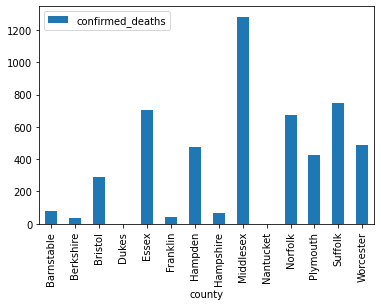

In [0]:
df_ma_county.plot(x='county', y='confirmed_deaths', kind='bar')

In [0]:
 ## run this if you want to export data in csv file
# df_nyt_ma.to_csv('df_nyt_ma.csv') 
# files.download('df_nyt_ma.csv')


* Other Data

##### Dataset: covid19_ecdc.covid_19_geographic_distribution_worldwide 


In [0]:
df_ecdc_usa = run_query('''
SELECT  date, month, year, daily_confirmed_cases, daily_deaths, confirmed_cases, deaths, countries_and_territories, geo_id, pop_data_2018 FROM `bigquery-public-data.covid19_ecdc.covid_19_geographic_distribution_worldwide` WHERE geo_id ='US' LIMIT 1000 ''')
df_ecdc_usa.head()

,date,month,year,daily_confirmed_cases,daily_deaths,confirmed_cases,deaths,countries_and_territories,geo_id,pop_data_2018
0,2019-12-31,12,2019,0,0,0,0,United_States_of_America,US,327167434
1,2020-01-01,1,2020,0,0,0,0,United_States_of_America,US,327167434
2,2020-01-02,1,2020,0,0,0,0,United_States_of_America,US,327167434
3,2020-01-03,1,2020,0,0,0,0,United_States_of_America,US,327167434
4,2020-01-04,1,2020,0,0,0,0,United_States_of_America,US,327167434


In [0]:
df_ecdc_usa.size

10000

In [0]:
sort_df = df_ecdc_usa.groupby(['countries_and_territories'], as_index=False)['deaths'].sum()
# df_new = sort_df[(sort_df['deaths'] != 0) & (sort_df['deaths'] > 1000)]
sort_df.sort_values('deaths', ascending=False)

,countries_and_territories,deaths
0,United_States_of_America,1956305



ICU Bed Plots
---



In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/Adamantia/covid19-mit-teamd004/master/ICU_beds_2018_2019.csv') 

fip_codes_df = pd.read_csv('https://raw.githubusercontent.com/Adamantia/covid19-mit-teamd004/master/county_fips.csv', encoding = "ISO-8859-1")

fip_codes_df['county_name'] = fip_codes_df['county_name'].apply(lambda x: x.replace(' County', ''))

fip_codes = fip_codes_df.set_index('county_name')['fips'].to_dict()

df['county_fips_code'] = df['County'].apply(lambda x: fip_codes.get(x))

df_county = df[pd.notnull(df['county_fips_code'])]

icu_by_state = df.groupby('State')[['ICU Beds']].sum()

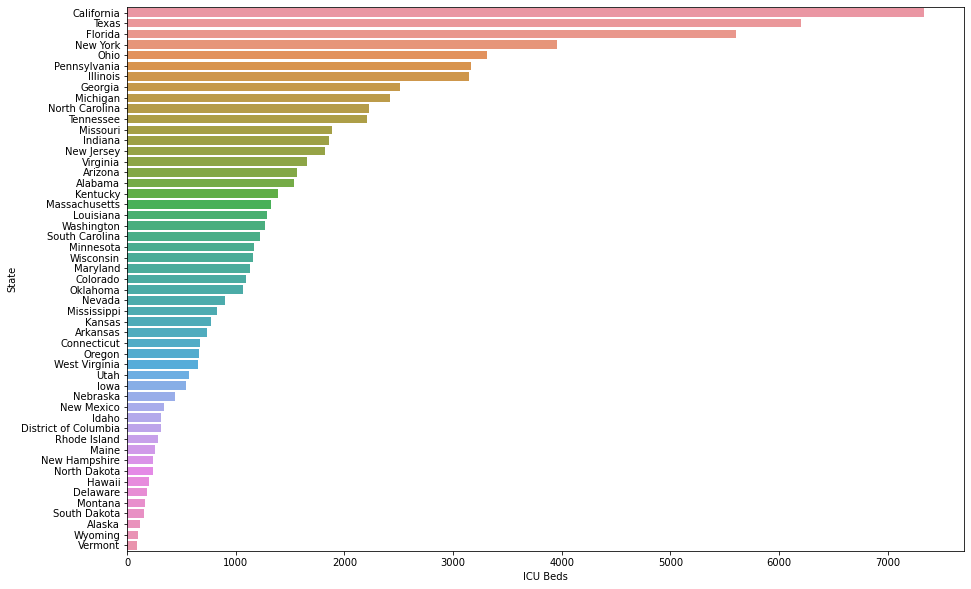

In [0]:
plt.figure(figsize=(15, 10))

ax = sns.barplot(x='ICU Beds', y='State', data=icu_by_state.reset_index().sort_values(by=['ICU Beds'], ascending=False))

plt.show(	)

In [0]:
url_cali = 'https://raw.githubusercontent.com/Adamantia/covid19-mit-teamd004/master/statsamerica_dataset/datasets/dataset_california.xls'
url_illinois = 'https://raw.githubusercontent.com/Adamantia/covid19-mit-teamd004/master/statsamerica_dataset/datasets/dataset_illinois.xls'
url_massachusetts = 'https://raw.githubusercontent.com/Adamantia/covid19-mit-teamd004/master/statsamerica_dataset/datasets/dataset_massachusetts.xls'
url_new_jersey = 'https://raw.githubusercontent.com/Adamantia/covid19-mit-teamd004/master/statsamerica_dataset/datasets/dataset_new_jersey.xls'
url_new_york ='https://raw.githubusercontent.com/Adamantia/covid19-mit-teamd004/master/statsamerica_dataset/datasets/dataset_new_york.xls'

data_cali = pd.read_html(url_cali)[0]
data_illinois = pd.read_html(url_illinois)[0]
data_massachusetts = pd.read_html(url_massachusetts)[0]
data_new_jersey = pd.read_html(url_new_jersey)[0]
data_new_york = pd.read_html(url_new_york)[0]

population_state_cali = data_cali.T[1:][1].astype(int).sum()
population_state_illinois = data_illinois.T[1:][1].astype(int).sum()
population_state_massachusetts = data_massachusetts.T[1:][1].astype(int).sum()
population_state_new_jersey = data_new_jersey.T[1:][1].astype(int).sum()
population_state_new_york = data_new_york.T[1:][1].astype(int).sum()

In [0]:
df_population = pd.DataFrame({"State":['California','Illinois', 'Massachusetts',  'New Jersey', 'New York'], "population": [population_state_cali, population_state_illinois, population_state_massachusetts, population_state_new_jersey, population_state_new_york]})
df_icu_beds = icu_by_state.reset_index()
df_icu_beds = df_icu_beds[(df_icu_beds['State'] == 'California') | (df_icu_beds['State'] == 'Illinois') | (df_icu_beds['State'] == 'New Jersey') | (df_icu_beds['State'] == 'New York') | (df_icu_beds['State'] == 'Massachusetts')]

In [0]:
df_icu_beds = df_icu_beds.sort_values(by=['State'], ascending=False)
df_population = df_population.sort_values(by=['State'], ascending=False)

In [0]:
normalized_data_100000 = np.array((df_icu_beds["ICU Beds"].astype(float)*100000))/np.array(df_population["population"].astype(float))
df_population["ICU Beds"]= df["ICU Beds"].values
df_population["normalized_data_100000"] = normalized_data_100000.tolist()
normalized_data = pd.DataFrame({'State': df_population["State"].values, 'normalized_data': df_population["normalized_data_100000"].values})

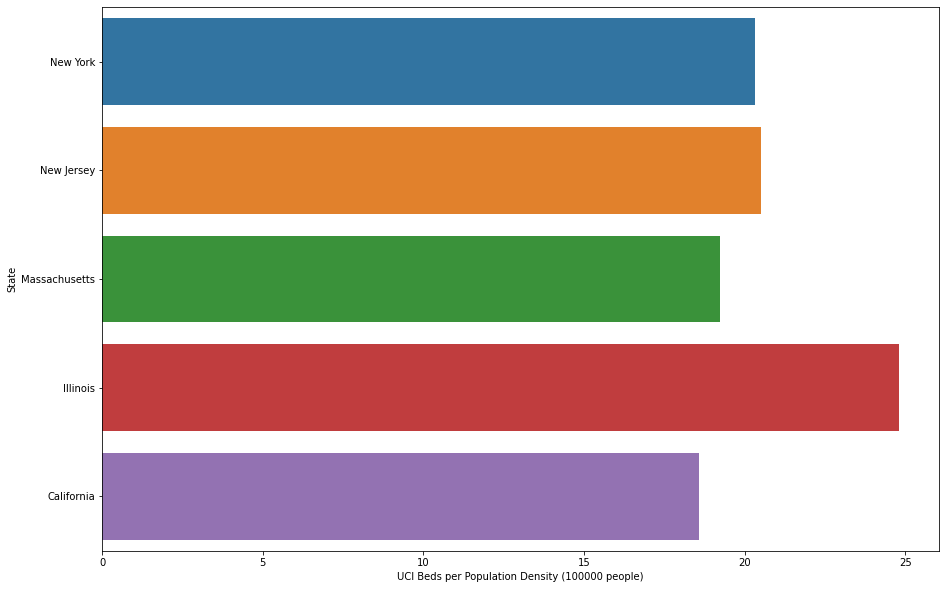

In [0]:
plt.figure(figsize=(15, 10))
ax = sns.barplot(x='normalized_data', y='State', data=normalized_data)
ax.set(xlabel='UCI Beds per Population Density (100000 people)', ylabel='State')
plt.show()


Country / County Lockdown Dates
---

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/Adamantia/covid19-mit-teamd004/master/countryLockdowndates.csv', parse_dates=['Date'])
df[(df['Province'] == 'California') | (df['Province'] == 'Illinois') | (df['Province'] == 'New Jersey') | (df['Province'] == 'New York') | (df['Province'] == 'Massachusetts')]

,Country/Region,Province,Date,Type,Reference
250,US,California,2020-03-19,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
260,US,Illinois,2020-03-21,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
268,US,Massachusetts,2020-03-24,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
277,US,New Jersey,2020-03-21,Full,https://en.wikipedia.org/wiki/2020_coronavirus...
279,US,New York,2020-03-22,Full,https://en.wikipedia.org/wiki/2020_coronavirus...


In [0]:
auth.authenticate_user()

In [0]:
project_id='mit-covid-19-datathon'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

NameError: ignored

In [0]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

In [0]:
df_covid19_usafacts = run_query('''
SELECT state,  
       SUM(confirmed_cases) as confirmed_cases,
       SUM(deaths) as deaths
FROM `bigquery-public-data.covid19_usafacts.summary`   
WHERE (
      state LIKE 'CA' or
      state LIKE 'IL' or
      state LIKE 'MA' or
      state LIKE 'NJ' or
      state LIKE 'NY'
        )
GROUP BY state
LIMIT 1000


''')
df_covid19_usafacts.head()





,state,confirmed_cases,deaths
0,CA,1814478,67140
1,IL,1842417,76716
2,MA,2045964,107697
3,NJ,4154597,225307
4,NY,11283424,778359


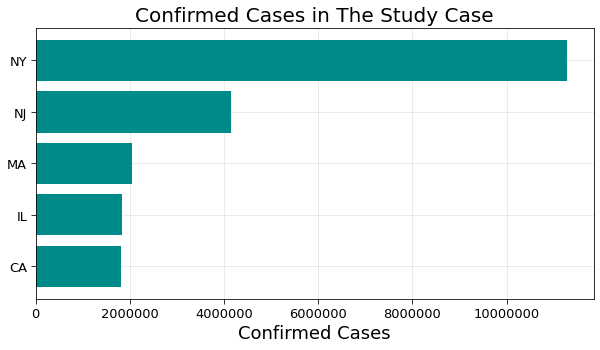

In [0]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_covid19_usafacts.sort_values('confirmed_cases')["state"].values,
         df_covid19_usafacts.sort_values('confirmed_cases')["confirmed_cases"].values,
         color="darkcyan")

plt.ticklabel_format(axis="x", style='plain')

plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Confirmed Cases in The Study Case",fontsize=20)
plt.grid(alpha=0.3)

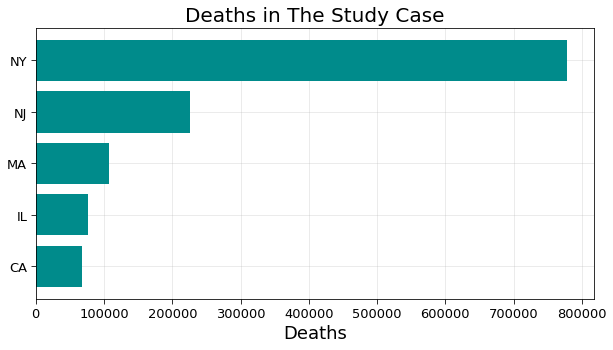

In [0]:
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_covid19_usafacts.sort_values('deaths')["state"].values,
         df_covid19_usafacts.sort_values('deaths')["deaths"].values,
         color="darkcyan")

plt.ticklabel_format(axis="x", style='plain')

plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths",fontsize=18)
plt.title("Deaths in The Study Case",fontsize=20)
plt.grid(alpha=0.3)

In [0]:
df_covid19_mobility_cases_deaths = run_query('''
SELECT date,  
       county_name,
       deaths,
       confirmed_cases
FROM `mit-covid-19-datathon.Team04trackD.mobility_deaths_cases_census_merged_MA`
ORDER BY date,  county_name
LIMIT 100
''')
df_covid19_mobility_cases_deaths.head()





,date,county_name,deaths,confirmed_cases
0,2020-02-15,Barnstable County,0,0
1,2020-02-15,Berkshire County,0,0
2,2020-02-15,Bristol County,0,0
3,2020-02-15,Bristol County,0,0
4,2020-02-15,Dukes County,0,0


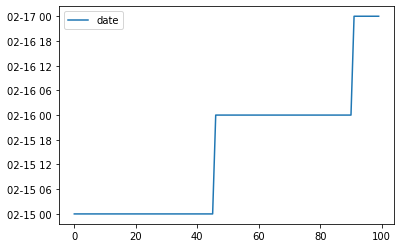

In [0]:
df_covid19_mobility_cases_deaths.plot()

# f = plt.figure(figsize=(10,5))
# ax1 = f.add_subplot(111)

# plt.axes(axisbelow=True)
# plt.barh(df_covid19_mobility_cases_deaths.sort_values('deaths')["county_name"].values,
#          df_covid19_mobility_cases_deaths.sort_values('deaths')["deaths"].values,
#          color="darkcyan")

# plt.ticklabel_format(axis="x", style='plain')

# plt.tick_params(size=5,labelsize = 13)
# plt.xlabel("Deaths",fontsize=18)
# plt.title("Deaths in The Study Case",fontsize=20)
# plt.grid(alpha=0.3)